# Домашнее задание. Нейросетевая классификация текстов

В этом домашнем задании вам предстоит самостоятельно решить задачу классификации текстов на основе семинарского кода. Мы будем использовать датасет [ag_news](https://paperswithcode.com/dataset/ag-news). Это датасет для классификации новостей на 4 темы: "World", "Sports", "Business", "Sci/Tech".

Установим модуль datasets, чтобы нам проще было работать с данными.

Импорт необходимых библиотек

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import datasets

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List
from statistics import mean
import string

from datetime import datetime

import os

import glob

import seaborn
seaborn.set(palette='summer')

In [2]:
seed = 228
np.random.seed(seed)
torch.manual_seed(seed)

In [3]:
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Артем\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных
Для вашего удобства, мы привели код обработки датасета в ноутбуке. Ваша задача --- обучить модель, которая получит максимальное возможное качество на тестовой части. 

In [5]:
# Загрузим датасет
dataset = datasets.load_dataset('ag_news')

Found cached dataset ag_news (C:/Users/Артем/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548)


  0%|          | 0/2 [00:00<?, ?it/s]

Как и в семинаре, выполним следующие шаги:
* Составим словарь
* Создадим класс WordDataset
* Выделим обучающую и тестовую часть, создадим DataLoader-ы.

In [6]:
words = Counter()

for example in tqdm(dataset['train']['text']):
    # Приводим к нижнему регистру и убираем пунктуацию
    prccessed_text = example.lower().translate(
        str.maketrans('', '', string.punctuation))

    for word in word_tokenize(prccessed_text):
        words[word] += 1


vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
counter_threshold = 25

for char, cnt in words.items():
    if cnt > counter_threshold:
        vocab.add(char)

print(f'Размер словаря: {len(vocab)}')

word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

  0%|          | 0/120000 [00:00<?, ?it/s]

Размер словаря: 11842


In [7]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        processed_text = self.data[idx]['text'].lower().translate(
            str.maketrans('', '', string.punctuation))
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [
            word2ind.get(word, self.unk_id) for word in word_tokenize(processed_text)
            ] 
        tokenized_sentence += [self.eos_id]

        train_sample = {
            "text": tokenized_sentence,
            "label": self.data[idx]['label']
        }

        return train_sample

    def __len__(self) -> int:
        return len(self.data)


def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>'], max_len=256) -> torch.Tensor:
    seq_lens = [len(x['text']) for x in input_batch]
    max_seq_len = min(max(seq_lens), max_len)

    new_batch = []
    for sequence in input_batch:
        sequence['text'] = sequence['text'][:max_seq_len]
        for _ in range(max_seq_len - len(sequence['text'])):
            sequence['text'].append(pad_id)

        new_batch.append(sequence['text'])
    
    sequences = torch.LongTensor(new_batch).to(device)
    labels = torch.LongTensor([x['label'] for x in input_batch]).to(device)

    new_batch = {
        'input_ids': sequences,
        'label': labels
    }

    return new_batch

In [8]:
train_dataset = WordDataset(dataset['train'])

idx = np.random.choice(np.arange(len(dataset['test'])), 5000, False)
eval_dataset = WordDataset(dataset['test'].select(idx))

test_idx = [x for x in np.arange(len(dataset['test'])) if x not in idx]
test_dataset = WordDataset(dataset['test'].select(idx))

batch_size = 32
train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

test_dataloader = DataLoader(
    eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Постановка задачи
Ваша задача -- получить максимальное возможное accuracy на `eval_dataloader`. Ниже приведена функция, которую вам необходимо запустить для обученной модели, чтобы вычислить качество её работы.

In [9]:
def evaluate(model, eval_dataloader) -> float:
    """
    Calculate accuracy on validation dataloader.
    """

    predictions = []
    target = []
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model(batch['input_ids'])
            predictions.append(logits.argmax(dim=1))
            target.append(batch['label'])
    
    predictions = torch.cat(predictions)
    target = torch.cat(target)
    accuracy = (predictions == target).float().mean().item()

    return accuracy

## Ход работы
Оценка за домашнее задание складывается из четырех частей:
### Запуск базовой модели с семинара на новом датасете (1 балл)
На семинаре мы создали модель, которая дает на нашей задаче довольно высокое качество. Ваша цель --- обучить ее и вычислить `score`, который затем можно будет использовать в качестве бейзлайна. 

В модели появится одно важное изменение: количество классов теперь равно не 2, а 4. Обратите на это внимание и найдите, что в коде создания модели нужно модифицировать, чтобы учесть это различие. 

### Проведение экспериментов по улучшению модели (2 балла за каждый эксперимент)
Чтобы улучшить качество базовой модели, можно попробовать различные идеи экспериментов. Каждый выполненный эксперимент будет оцениваться в 2 балла. Для получения полного балла за этот пункт вам необходимо выполнить по крайней мере 2 эксперимента. Не расстраивайтесь, если какой-то эксперимент не дал вам прироста к качеству: он все равно зачтется, если выполнен корректно. 

Вот несколько идей экспериментов:
* **Модель RNN**. Попробуйте другие нейросетевые модели --- LSTM и GRU. Мы советуем обратить внимание на [GRU](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html), так как интерфейс этого класса ничем не отличается от обычной Vanilla RNN, которую мы использовали на семинаре.
* **Увеличение количества рекуррентных слоев модели**. Это можно сделать с помощью параметра `num_layers` в классе `nn.RNN`. В такой модели выходы первой RNN передаются в качестве входов второй RNN и так далее. 
* **Изменение архитектуры после применения RNN**. В базовой модели используется агрегация со всех эмбеддингов. Возможно, вы захотите конкатенировать результат агрегации и эмбеддинг с последнего токена.
* **Подбор гиперпараметров и обучение до сходимости**. Возможно, для получения более высокого качества просто необходимо увеличить количество эпох обучения нейросети, а также попробовать различные гиперпараметры: размер словаря, `dropout_rate`, `hidden_dim`.

Обратите внимание, что главное правило проведения экспериментов --- необходимо совершать одно архитектурное изменение в одном эксперименте. Если вы совершите несколько изменений, то будет неясно, какое именно из изменений дало прирост к качеству. 

### Получение высокого качества (3 балла)
В конце вашей работы вы должны указать, какая из моделей дала лучший результат, и вывести качество, которое дает лучшая модель, с помощью функции `evaluate`. Ваша модель будет оцениваться по метрике `accuracy` следующим образом:
* $accuracy < 0.9$ --- 0 баллов;
* $0.9 \leqslant accuracy < 0.91$ --- 1 балл;
* $0.91 \leqslant accuracy < 0.915$ --- 2 балла;
* $0.915 \leqslant accuracy$ --- 3 балла.

### Оформление отчета (2 балла)
В конце работы подробно опишите все проведенные эксперименты. 
* Укажите, какие из экспериментов принесли улучшение, а какие --- нет. 
* Проанализируйте графики сходимости моделей в проведенных экспериментах. Являются ли колебания качества обученных моделей существенными в зависимости от эпохи обучения, или же сходимость стабильная? 
* Укажите, какая модель получилась оптимальной.

Желаем удачи!

## Часть 1. Запуск базовой модели с семинара на новом датасете.

Модель

In [10]:
class CharLM(nn.Module):
    def __init__(
        self, 
        hidden_dim: int, 
        vocab_size: int, 
        num_classes: int = 4,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, final = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        elif self.aggregation_type == 'none':
            output = final[-1,:,:]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

Train Loop

In [11]:
bool("")

False

In [12]:
def train(model,
          criterion,
          optimizer,
          train_dataloader,
          val_dataloader,
          max_epoch,
          scheduler=None,
          name=None):
    '''
    Method for model training.
    Returns best accuracy along corresponding epoch
    '''
    name=f'{type(model).__name__}_{model.aggregation_type}' if not name else name
    dir_name = f'{name.replace(" ", "_")}_{datetime.now().strftime("%d.%m.%y_%H.%M")}'
    os.makedirs(f'./{dir_name}', exist_ok=True)
    
    losses_train = []
    acc = []
    
    print(f'STARTING TRAINING: {name}')
    print()
    
    max_accuracy = 0
    for epoch in range(max_epoch):
        epoch_losses_train = []
        train_pb = tqdm(train_dataloader)
        model.train()
        for i, X in enumerate(train_pb):
            optimizer.zero_grad()
            logits = model(X['input_ids'])
            loss = criterion(logits, X['label'])
            loss.backward()
            optimizer.step()
    
            epoch_losses_train.append(loss.item())
            epoch_losses_train_mean = mean(epoch_losses_train)
            train_pb.set_description(f'epoch: {epoch} avg loss: {epoch_losses_train_mean:.3f}')
    
        model.eval()
        accuracy = evaluate(model, val_dataloader)
        if max_accuracy < accuracy:
            max_accuracy = accuracy
            print(f'Найдена новая лучшая точность: {accuracy:.3f} epoch {epoch} сохранено в "{dir_name}/{name.replace(" ", "_")}_{accuracy:.3f}.ckpt"')
            prev = glob.glob(f'./{dir_name}/*.ckpt')
            if prev:
                os.remove(prev[0])
            torch.save(model.state_dict(), f'./{dir_name}/{name.replace(" ", "_")}_{accuracy:.3f}.ckpt')
        acc.append(accuracy)
    
        if scheduler:
            scheduler.step()
    
        losses_train.append(epoch_losses_train_mean)
    
    print(f'Лучший Accuracy: {max(acc):.3f} на эпохе {acc.index(max(acc))}')
    figure, axis = plt.subplots(1, 2)
    axis[0].plot(np.arange(len(losses_train)), losses_train, color='red', label='train')
    axis[0].set_title('Losses')
    axis[0].legend()
    
    axis[1].plot(np.arange(len(acc)), acc, color='red', label='val')
    axis[1].set_title('Accuracy')
    axis[1].legend()
    plt.show()
    return max(acc), acc.index(max(acc)), dir_name


Обучение

STARTING TRAINING: CharLM_max



  0%|          | 0/3750 [00:00<?, ?it/s]

Найдена новая лучшая точность: 0.891 epoch 0 сохранено в "CharLM_max_26.05.23_02.49/CharLM_max_0.891.ckpt"


  0%|          | 0/3750 [00:00<?, ?it/s]

Найдена новая лучшая точность: 0.895 epoch 1 сохранено в "CharLM_max_26.05.23_02.49/CharLM_max_0.895.ckpt"


  0%|          | 0/3750 [00:00<?, ?it/s]

Найдена новая лучшая точность: 0.901 epoch 2 сохранено в "CharLM_max_26.05.23_02.49/CharLM_max_0.901.ckpt"


  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

Найдена новая лучшая точность: 0.905 epoch 4 сохранено в "CharLM_max_26.05.23_02.49/CharLM_max_0.905.ckpt"


  0%|          | 0/3750 [00:00<?, ?it/s]

Найдена новая лучшая точность: 0.909 epoch 5 сохранено в "CharLM_max_26.05.23_02.49/CharLM_max_0.909.ckpt"


  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

Лучший Accuracy: 0.909 на эпохе 5


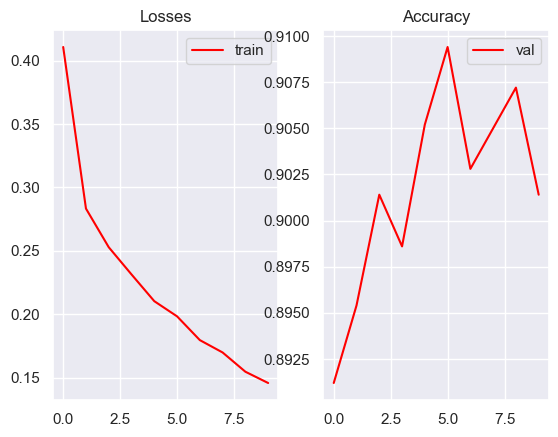

<All keys matched successfully>

In [27]:
char_LM = CharLM(hidden_dim=256, vocab_size=len(vocab)).to(device)
optimizer = torch.optim.Adam(char_LM.parameters())
criterion = nn.CrossEntropyLoss()
max_epoch = 10

max_acc, best_epoch, dir_name = train(char_LM, 
                                      criterion, 
                                      optimizer, 
                                      train_dataloader, 
                                      eval_dataloader, 
                                      max_epoch, None, 
                                      f'{type(char_LM).__name__}_{char_LM.aggregation_type}')

char_LM.load_state_dict(torch.load(f'./{glob.glob(f"{dir_name}/*.ckpt")[0]}'))

Test

In [28]:
char_LM.eval()
charLM_test_accuracy = evaluate(char_LM, test_dataloader)
print(f'Точность дефолтного CharLM на тестовой выборке: {charLM_test_accuracy}')

Точность дефолтного CharLM на тестовой выборке: 0.9093999862670898


## Часть 2. Проведение экспериментов по улучшению модели

### Эксперимент 1. Изначальная модель (CharLM), способы аггрегации, сравенение. MAX, MEAN. 

STARTING TRAINING: CharLM_max



  0%|          | 0/3750 [00:00<?, ?it/s]

Найдена новая лучшая точность: 0.891 epoch 0 сохранено в "CharLM_max_25.05.23_23.31/CharLM_max_0.891.ckpt"


  0%|          | 0/3750 [00:00<?, ?it/s]

Найдена новая лучшая точность: 0.899 epoch 1 сохранено в "CharLM_max_25.05.23_23.31/CharLM_max_0.899.ckpt"


  0%|          | 0/3750 [00:00<?, ?it/s]

Найдена новая лучшая точность: 0.903 epoch 2 сохранено в "CharLM_max_25.05.23_23.31/CharLM_max_0.903.ckpt"


  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

Найдена новая лучшая точность: 0.905 epoch 4 сохранено в "CharLM_max_25.05.23_23.31/CharLM_max_0.905.ckpt"


  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

Найдена новая лучшая точность: 0.907 epoch 6 сохранено в "CharLM_max_25.05.23_23.31/CharLM_max_0.907.ckpt"


  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

Лучший Accuracy: 0.907 на эпохе 6


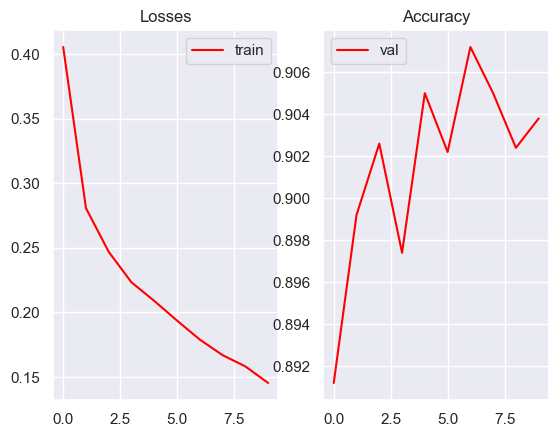

STARTING TRAINING: CharLM_mean



  0%|          | 0/3750 [00:00<?, ?it/s]

Найдена новая лучшая точность: 0.895 epoch 0 сохранено в "CharLM_mean_25.05.23_23.39/CharLM_mean_0.895.ckpt"


  0%|          | 0/3750 [00:00<?, ?it/s]

Найдена новая лучшая точность: 0.909 epoch 1 сохранено в "CharLM_mean_25.05.23_23.39/CharLM_mean_0.909.ckpt"


  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

Лучший Accuracy: 0.909 на эпохе 1


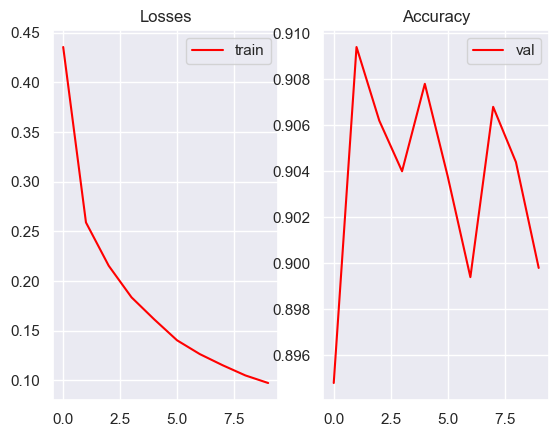

STARTING TRAINING: CharLM_none



  0%|          | 0/3750 [00:00<?, ?it/s]

Найдена новая лучшая точность: 0.246 epoch 0 сохранено в "CharLM_none_25.05.23_23.47/CharLM_none_0.246.ckpt"


  0%|          | 0/3750 [00:00<?, ?it/s]

Найдена новая лучшая точность: 0.249 epoch 1 сохранено в "CharLM_none_25.05.23_23.47/CharLM_none_0.249.ckpt"


  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

Найдена новая лучшая точность: 0.250 epoch 4 сохранено в "CharLM_none_25.05.23_23.47/CharLM_none_0.250.ckpt"


  0%|          | 0/3750 [00:00<?, ?it/s]

Найдена новая лучшая точность: 0.252 epoch 5 сохранено в "CharLM_none_25.05.23_23.47/CharLM_none_0.252.ckpt"


  0%|          | 0/3750 [00:00<?, ?it/s]

Найдена новая лучшая точность: 0.255 epoch 6 сохранено в "CharLM_none_25.05.23_23.47/CharLM_none_0.255.ckpt"


  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

Лучший Accuracy: 0.255 на эпохе 6


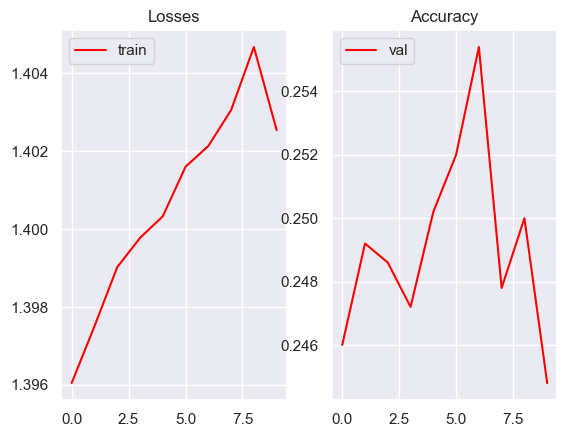

In [15]:
aggregation_types = ['max', 'mean', 'none']
max_epoch = 10
char_LM_agg_results = {}
agg_types_models = {}

for aggregation_type in aggregation_types:
    model = CharLM(hidden_dim=256, 
                   vocab_size=len(vocab), 
                   aggregation_type=aggregation_type).to(device)
    optimizer = torch.optim.Adam(model.parameters())
    criterion = nn.CrossEntropyLoss()
    best_acc, best_epoch, dir_name = train(model, 
                                criterion, 
                                optimizer, 
                                train_dataloader, 
                                eval_dataloader, 
                                max_epoch, 
                                None, 
                                f'{type(model).__name__}_{model.aggregation_type}')
    model.load_state_dict(torch.load(f'./{glob.glob(f"{dir_name}/*.ckpt")[0]}'))
    agg_types_models[aggregation_type] = model
    
    char_LM_agg_results[aggregation_type] = (best_acc, best_epoch)

In [16]:
print(f'Результаты CHARLM {max_epoch} epochs на тестовой выборке:')
for aggregation_type in aggregation_types:
    agg_type_acc = evaluate(agg_types_models[aggregation_type], test_dataloader)
    print(f'{aggregation_type}: {agg_type_acc}')

Результаты CHARLM 10 epochs на тестовой выборке:
max: 0.9071999788284302
mean: 0.9093999862670898
none: 0.25540000200271606


### Эксперимент 2. GRU.

Модель

In [17]:
class GRUModel(nn.Module):
    def __init__(
        self, 
        hidden_dim: int, 
        vocab_size: int, 
        num_classes: int = 4,
        aggregation_type: str = 'max',
        gru_num_layers: int = 1,
        gru_dropout: int = 0
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.gru = nn.GRU(hidden_dim, hidden_dim, batch_first=True, num_layers=gru_num_layers, dropout=gru_dropout)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, final = self.gru(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")
        
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

Обучение

STARTING TRAINING: GRU max aggregation, CrossEntropy, Adam



  0%|          | 0/3750 [00:00<?, ?it/s]

Найдена новая лучшая точность: 0.903 epoch 0 сохранено в "GRU_max_aggregation,_CrossEntropy,_Adam_25.05.23_23.58/GRU_max_aggregation,_CrossEntropy,_Adam_0.903.ckpt"


  0%|          | 0/3750 [00:00<?, ?it/s]

Найдена новая лучшая точность: 0.915 epoch 1 сохранено в "GRU_max_aggregation,_CrossEntropy,_Adam_25.05.23_23.58/GRU_max_aggregation,_CrossEntropy,_Adam_0.915.ckpt"


  0%|          | 0/3750 [00:00<?, ?it/s]

Найдена новая лучшая точность: 0.916 epoch 2 сохранено в "GRU_max_aggregation,_CrossEntropy,_Adam_25.05.23_23.58/GRU_max_aggregation,_CrossEntropy,_Adam_0.916.ckpt"


  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

Найдена новая лучшая точность: 0.916 epoch 4 сохранено в "GRU_max_aggregation,_CrossEntropy,_Adam_25.05.23_23.58/GRU_max_aggregation,_CrossEntropy,_Adam_0.916.ckpt"


  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

Лучший Accuracy: 0.916 на эпохе 4


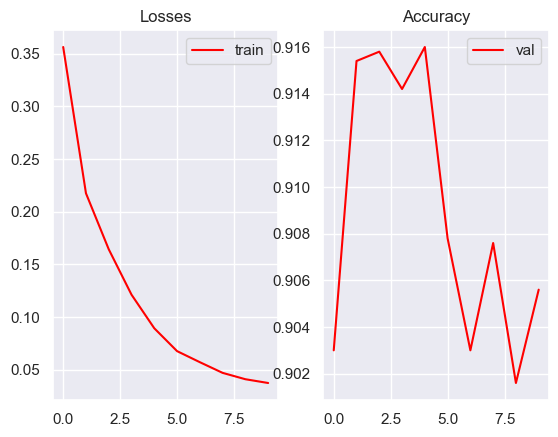

<All keys matched successfully>

In [18]:
gru = GRUModel(hidden_dim=256, vocab_size=len(vocab)).to(device)
optimizer = torch.optim.Adam(gru.parameters())
criterion = nn.CrossEntropyLoss()
max_epoch = 10

max_acc, best_epoch, dir_name = train(gru, 
                            criterion, 
                            optimizer, 
                            train_dataloader, 
                            eval_dataloader, 
                            max_epoch, 
                            None, 
                            'GRU max aggregation, CrossEntropy, Adam')
gru.load_state_dict(torch.load(f'./{glob.glob(f"{dir_name}/*.ckpt")[0]}'))

Test

In [19]:
gru.eval()
gru_test_accuracy = evaluate(gru, test_dataloader)
print(f'Точность gru на тестовой выборке: {gru_test_accuracy}')

Точность gru на тестовой выборке: 0.9159999489784241


### Эксперимент 3. GRU с нексолькими слоями.

Train

STARTING TRAINING: GRU Num layers2 CrossEntropy Adam



  0%|          | 0/3750 [00:00<?, ?it/s]

Найдена новая лучшая точность: 0.908 epoch 0 сохранено в "GRU_Num_layers2_CrossEntropy_Adam_26.05.23_00.13/GRU_Num_layers2_CrossEntropy_Adam_0.908.ckpt"


  0%|          | 0/3750 [00:00<?, ?it/s]

Найдена новая лучшая точность: 0.911 epoch 1 сохранено в "GRU_Num_layers2_CrossEntropy_Adam_26.05.23_00.13/GRU_Num_layers2_CrossEntropy_Adam_0.911.ckpt"


  0%|          | 0/3750 [00:00<?, ?it/s]

Найдена новая лучшая точность: 0.918 epoch 2 сохранено в "GRU_Num_layers2_CrossEntropy_Adam_26.05.23_00.13/GRU_Num_layers2_CrossEntropy_Adam_0.918.ckpt"


  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

Лучший Accuracy: 0.918 на эпохе 2


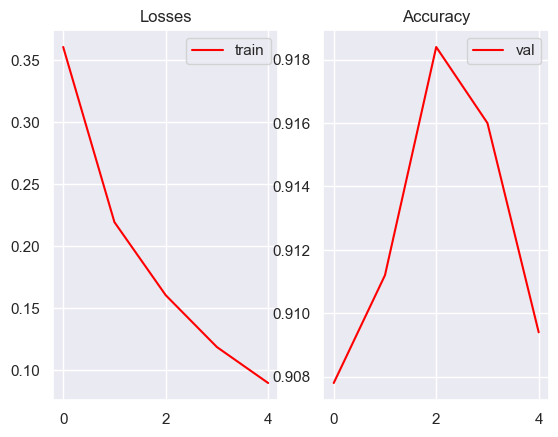

STARTING TRAINING: GRU Num layers3 CrossEntropy Adam



  0%|          | 0/3750 [00:00<?, ?it/s]

Найдена новая лучшая точность: 0.905 epoch 0 сохранено в "GRU_Num_layers3_CrossEntropy_Adam_26.05.23_00.20/GRU_Num_layers3_CrossEntropy_Adam_0.905.ckpt"


  0%|          | 0/3750 [00:00<?, ?it/s]

Найдена новая лучшая точность: 0.914 epoch 1 сохранено в "GRU_Num_layers3_CrossEntropy_Adam_26.05.23_00.20/GRU_Num_layers3_CrossEntropy_Adam_0.914.ckpt"


  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

Найдена новая лучшая точность: 0.914 epoch 4 сохранено в "GRU_Num_layers3_CrossEntropy_Adam_26.05.23_00.20/GRU_Num_layers3_CrossEntropy_Adam_0.914.ckpt"
Лучший Accuracy: 0.914 на эпохе 4


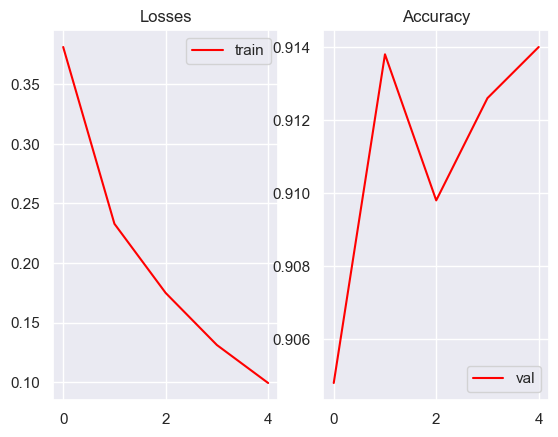

STARTING TRAINING: GRU Num layers4 CrossEntropy Adam



  0%|          | 0/3750 [00:00<?, ?it/s]

Найдена новая лучшая точность: 0.905 epoch 0 сохранено в "GRU_Num_layers4_CrossEntropy_Adam_26.05.23_00.29/GRU_Num_layers4_CrossEntropy_Adam_0.905.ckpt"


  0%|          | 0/3750 [00:00<?, ?it/s]

Найдена новая лучшая точность: 0.909 epoch 1 сохранено в "GRU_Num_layers4_CrossEntropy_Adam_26.05.23_00.29/GRU_Num_layers4_CrossEntropy_Adam_0.909.ckpt"


  0%|          | 0/3750 [00:00<?, ?it/s]

Найдена новая лучшая точность: 0.911 epoch 2 сохранено в "GRU_Num_layers4_CrossEntropy_Adam_26.05.23_00.29/GRU_Num_layers4_CrossEntropy_Adam_0.911.ckpt"


  0%|          | 0/3750 [00:00<?, ?it/s]

Найдена новая лучшая точность: 0.915 epoch 3 сохранено в "GRU_Num_layers4_CrossEntropy_Adam_26.05.23_00.29/GRU_Num_layers4_CrossEntropy_Adam_0.915.ckpt"


  0%|          | 0/3750 [00:00<?, ?it/s]

Лучший Accuracy: 0.915 на эпохе 3


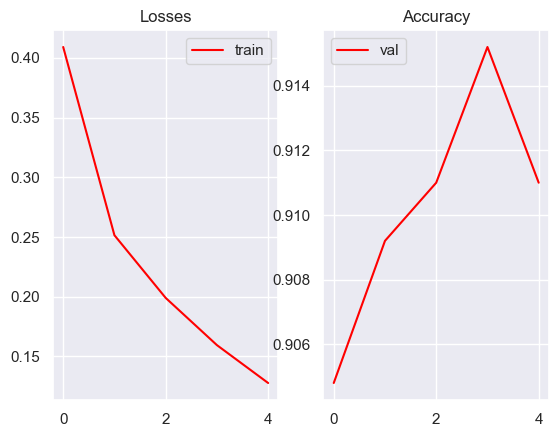

In [20]:
num_layers = [2, 3, 4]
max_epoch = 5
gru_nl_results = {}
gru_models = {}

for num in num_layers:
    model = GRUModel(hidden_dim=256, 
               vocab_size=len(vocab), 
               gru_num_layers=num).to(device)
    optimizer = torch.optim.Adam(model.parameters())
    criterion = nn.CrossEntropyLoss()
    best_acc, best_epoch, dir_name = train(model, 
                                criterion, 
                                optimizer, 
                                train_dataloader, 
                                eval_dataloader, 
                                max_epoch, 
                                None, 
                                f'GRU Num layers{num} CrossEntropy Adam')
    model.load_state_dict(torch.load(f'./{glob.glob(f"{dir_name}/*.ckpt")[0]}'))
    gru_models[num] = model
    
    gru_nl_results[num] = (best_acc, best_epoch)

Test

In [21]:
print(f'Результаты GRU {max_epoch} epochs на тестовой выборке:')
for num in num_layers:
    num_acc = evaluate(gru_models[num], test_dataloader)
    print(f'{num} layers: {num_acc}')

Результаты GRU 5 epochs на тестовой выборке:
2 layers: 0.91839998960495
3 layers: 0.9139999747276306
4 layers: 0.9151999950408936


### Эксперимент 4. Многослойная GRU с dropout

STARTING TRAINING: GRUModel_max_0.2



  0%|          | 0/3750 [00:00<?, ?it/s]

Найдена новая лучшая точность: 0.906 epoch 0 сохранено в "GRUModel_max_0.2_26.05.23_01.12/GRUModel_max_0.2_0.906.ckpt"


  0%|          | 0/3750 [00:00<?, ?it/s]

Найдена новая лучшая точность: 0.911 epoch 1 сохранено в "GRUModel_max_0.2_26.05.23_01.12/GRUModel_max_0.2_0.911.ckpt"


  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

Найдена новая лучшая точность: 0.915 epoch 3 сохранено в "GRUModel_max_0.2_26.05.23_01.12/GRUModel_max_0.2_0.915.ckpt"


  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

Лучший Accuracy: 0.915 на эпохе 3


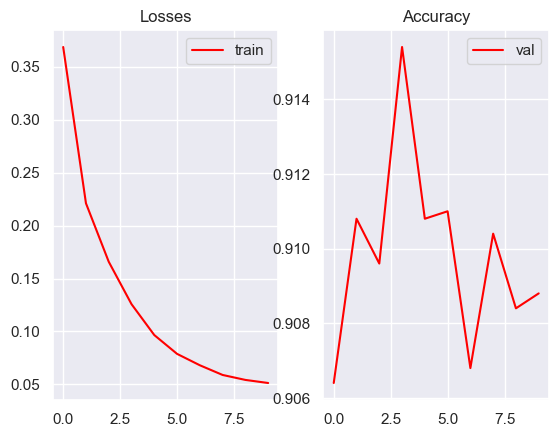

STARTING TRAINING: GRUModel_max_0.3



  0%|          | 0/3750 [00:00<?, ?it/s]

Найдена новая лучшая точность: 0.903 epoch 0 сохранено в "GRUModel_max_0.3_26.05.23_01.22/GRUModel_max_0.3_0.903.ckpt"


  0%|          | 0/3750 [00:00<?, ?it/s]

Найдена новая лучшая точность: 0.917 epoch 1 сохранено в "GRUModel_max_0.3_26.05.23_01.22/GRUModel_max_0.3_0.917.ckpt"


  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

Лучший Accuracy: 0.917 на эпохе 1


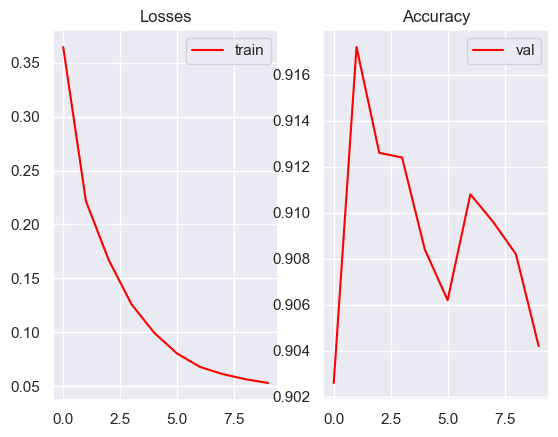

STARTING TRAINING: GRUModel_max_0.5



  0%|          | 0/3750 [00:00<?, ?it/s]

Найдена новая лучшая точность: 0.894 epoch 0 сохранено в "GRUModel_max_0.5_26.05.23_01.32/GRUModel_max_0.5_0.894.ckpt"


  0%|          | 0/3750 [00:00<?, ?it/s]

Найдена новая лучшая точность: 0.912 epoch 1 сохранено в "GRUModel_max_0.5_26.05.23_01.32/GRUModel_max_0.5_0.912.ckpt"


  0%|          | 0/3750 [00:00<?, ?it/s]

Найдена новая лучшая точность: 0.915 epoch 2 сохранено в "GRUModel_max_0.5_26.05.23_01.32/GRUModel_max_0.5_0.915.ckpt"


  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

Лучший Accuracy: 0.915 на эпохе 2


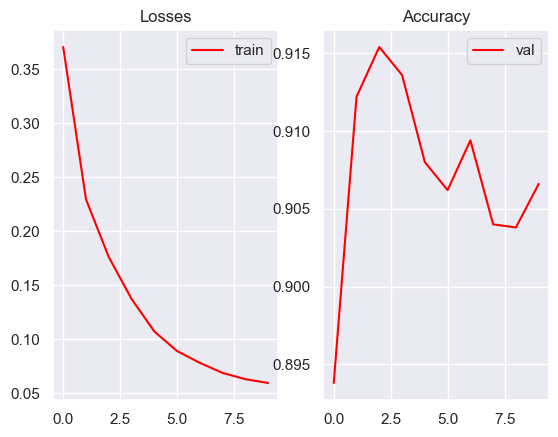

In [25]:
dropouts = [0.2, 0.3, 0.5]
max_epoch = 10
gru_dropout_results = {}
gru_dropout_models = {}

for dropout in dropouts:
    model = GRUModel(hidden_dim=256, 
               vocab_size=len(vocab),
               gru_num_layers=2,
               gru_dropout=dropout).to(device)
    optimizer = torch.optim.Adam(model.parameters())
    criterion = nn.CrossEntropyLoss()
    best_acc, best_epoch, dir_name = train(model, 
                                criterion, 
                                optimizer, 
                                train_dataloader, 
                                eval_dataloader, 
                                max_epoch, 
                                None, f'{type(model).__name__}_{model.aggregation_type}_{dropout}')
    model.load_state_dict(torch.load(f'./{glob.glob(f"{dir_name}/*.ckpt")[0]}'))
    gru_dropout_models[dropout] = model
    
    gru_dropout_results[dropout] = (best_acc, best_epoch)

In [26]:
print(f'Результаты GRU, 2 layers, dopout, {max_epoch} epochs на тестовой выборке:')
for dropout in dropouts:
    dropout_acc = evaluate(gru_dropout_models[dropout], test_dataloader)
    print(f'{dropout} dropout: {dropout_acc}')

Результаты GRU, 2 layers, dopout, 10 epochs на тестовой выборке:
0.2 layers: 0.915399968624115
0.3 layers: 0.917199969291687
0.5 layers: 0.915399968624115


# Часть 3. Отчет по экспериментам с моделью CharLM

## Baseline модель

Модель CharLM имеет следующую архитектуру:

- Один RNN слой
- Один линейный слой размерности hidden_dim x hidden_dim с дропаутом 0.1
- Head - линейный слой размерности hidden_dim x 4

Выходы RNN агрегируются с помощью функции max.

После 4 эпох модель начинает переобучаться, что приводит к снижению качества.

Точность baseline модели составляет 0.909.

## Эксперимент №1: Сравнение способов агрегации

В этом эксперименте сравниваются различные способы агрегации. 

Были протестированы следующие способы агрегации:

- `max`: 0.907
- `mean`: 0.909
- `none`: 0.255

Baseline модель также начинает переобучаться примерно на тех же эпохах.

Наилучший результат показал способ агрегации `max`.

## Эксперимент №2: Модель GRU

В этом эксперименте baseline модель была модифицирована: вместо RNN слоя был использован GRU слой.

Переобучение происходит еще раньше, примерно после первой эпохи.

Результат эксперимента: точность составляет 0.916.

Модель с GRU оказалась лучше, чем baseline модель.

## Эксперимент №3: Модель с несколькими слоями в GRU блоке

В этом эксперименте была протестирована модель из эксперимента №2 с разным числом слоев в GRU блоке. Число слоев варьировалось в диапазоне от 2 до 4.

Переобучение происходит после 2 эпох.

Результаты эксперимента:

- 2 слоя: 0.918
- 3 слоя: 0.913
- 4 слоя: 0.915

Модель с 2 слоями GRU показала лучшие результаты по сравнению с моделями, содержащими 3 или 4 слоя.

## Эксперимент №4: Модель с 2 слоями в GRU блоке и дропаутом

В этом эксперименте была протестирована модель из эксперимента №3, в которую был добавлен дропаут между слоями GRU. Значение дропаута варьировалось в диапазоне от 0.2 до 0.5.

Переобучение происходит раньше или позже в зависимости от значения дропаута. Наблюдается незначительное изменение в точности модели.

Результаты эксперимента:

- Dropout 0.2, 2 слоя: 0.915
- Dropout 0.3, 2 слоя: 0.917
- Dropout 0.5, 2 слоя: 0.915

# Наилучшее качество достигается в эксперименте №3, где использовалось 2 слоя GRU с точностью 0.918.